# CSE 168 Lab 3 - Option 1

This notebook describes CSE 168 Lab 3 - Option 1 for students Shawn Duong, Chloe Engel, Charison Gill-Branion, and Isabella Montoya in the Fall semester of 2022.

For this lab, we are training a model to detect 7 hand gestures. This is based on the tutorial given in the lab handout by Nicholas Renotte.

Before running this notebook, one should set up the venv and install the dependencies as per the tutorial. You need not do this in Google Colab, though:

```
python -m venv tfod

source tfod/bin/activate # Linux
.\tfod\Scripts\activate # Windows 

python -m pip install --upgrade pip
pip install ipykernel
python -m ipykernel install --user --name=tfodj
```

Make sure that the notebook's kernel is tfodj as well.

We've also made this notebook to work via a native Jupyter Notebook or via Google Colab. Google Colab cannot access the webcam, however. To use the webcam on Colab, we refer to and thank the Google Colab documentation: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=SucxddsPhOmj

## Setup

In [1]:
# Set this to True if you want to skip the collection phase, such as
# for when you've already collected training images.
skipCollection = True

# Set this to True if you want to skip the training phase, such as for
# when you've already trained the model.
skipTraining = False

# Set this to True if you're using Google Colab. This will trigger a
# webcam workaround.
usingColab = True

# Part 1: Collecting Training Images

## Step 1: Install and Import Dependencies

We must install and import the dependencies. We need opencv-python in order to use computer vision related functionalities.

In [2]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import cv2
import os
import time

## Step 2: Define the Images to Collect

We are collecting the hand gestures that make up "Hello World," and saving 5 images per gesture. We can collect more training images by just re-running the code in step 4, though.

In [6]:
# The gestures we are training the model to detect.
labels = ["h", "e", "l", "o", "w", "r", "d"]

# The number of training images per gesture we will take.
nImgs = 5

## Step 3: Set Up File Structure

We are going to save everything in `./tensorflow/workspaces/images/training_images/`.

In [7]:
# The path to store our training images in.
path = "./tensorflow/workspace/images/training_images/"

# Create the path if it does not exist.
if not os.path.exists(path):
    os.makedirs(path)

## Step 4: Capture Training Images From Webcam

We capture 5 images per gesture from the webcam. We can press 'q' on our keyboard to quit early, or 'c' to capture an image when we're ready.

In [8]:
if not skipCollection:

    # Native Jupyter notebook can just access webcam directly.
    if not usingColab:
    
        cap = cv2.VideoCapture(0)

        # Loop for all gestures we want to train.
        for label in labels:

            print(f"Capturing images for: {label}")

            completed = 0
            earlyExit = False

            # Loop for however many images we wish to capture per gesture.
            while completed < nImgs:

                # Read from the camera and show it to us.
                _, frame = cap.read()

                try:
                    cv2.imshow("Frame", frame)
                except:
                    continue

                # Webcam refresh rate.
                time.sleep(0.01)

                # Press 'q' to quit.
                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    earlyExit = True
                    break

                # Press 'c' to capture.
                elif key == ord('c'):
                    # Capture and save the image.
                    completed += 1
                    print(f"Capturing image {completed}/{nImgs}")
                    cv2.imwrite(path+f"{label}_{int(time.time())}.jpg", frame)

            if earlyExit:
                break

        cap.release()
        cv2.destroyAllWindows()

    # Using Colab means that we can't access the webcam directly and must do a
    # workaround.
    else:

        from IPython.display import display, Javascript
        from google.colab.output import eval_js
        from base64 import b64decode

        def take_photo(filename='photo.jpg', quality=0.8):
          js = Javascript('''
            async function takePhoto(quality) {
              const div = document.createElement('div');
              const capture = document.createElement('button');
              capture.textContent = 'Capture';
              div.appendChild(capture);

              const video = document.createElement('video');
              video.style.display = 'block';
              const stream = await navigator.mediaDevices.getUserMedia({video: true});

              document.body.appendChild(div);
              div.appendChild(video);
              video.srcObject = stream;
              await video.play();

              // Resize the output to fit the video element.
              google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

              // Wait for Capture to be clicked.
              await new Promise((resolve) => capture.onclick = resolve);

              const canvas = document.createElement('canvas');
              canvas.width = video.videoWidth;
              canvas.height = video.videoHeight;
              canvas.getContext('2d').drawImage(video, 0, 0);
              stream.getVideoTracks()[0].stop();
              div.remove();
              return canvas.toDataURL('image/jpeg', quality);
            }
            ''')
          display(js)
          data = eval_js('takePhoto({})'.format(quality))
          binary = b64decode(data.split(',')[1])
          with open(filename, 'wb') as f:
            f.write(binary)
          return binary, filename

        from IPython.display import Image

        # Loop for all gestures we want to train.
        for label in labels:

            print(f"Capturing images for: {label}")

            completed = 0

            # Loop for however many images we wish to capture per gesture.
            while completed < nImgs:

                # Read from the camera and show it to us.
                binary, photo = take_photo()
                display(Image(photo))

                # Capture and save the image.
                completed += 1
                print(f"Capturing image {completed}/{nImgs}")
                with open(path+f"{label}_{int(time.time())}.jpg", "wb") as f:
                    f.write(binary)

## Step 5: Segment the Images Into Training and Testing

Annotate the images with labelimg or Label Studio, and then move some into training and others into testing along with their annotations. To clarify: move a large number of images into `./tensorflow/workspaces/images/train/` and others into `./tensorflow/workspaces/images/test/`.

# Part 2: Training and Detection

## Step 1: Download and Compile TFOD

We must download and install TFOD from TensorFlow's GitHub. We must compile all the proto files to do so. This is different for Linux and Windows.

In [9]:
# Make the repository where we will clone the TensorFlow models repo.
if not os.path.exists("./models/"):
    os.makedirs("./models/")
    !git clone https://github.com/tensorflow/models ./models/
    
# For Linux.
if os.name == "posix":
    
    # For Arch Linux.
    if "arch" in os.uname().release:
        !pacman -Syu protobuf
        
    # If you're not using Arch, you're probably on Ubuntu or some
    # other Debian derivative and use apt.
    else:
        !apt-get install protobuf-compiler
        
    # Compile the proto files.
    !cd ./models/research && protoc object_detection/protos/*.proto --python_out=. \
     && cp object_detection/packages/tf2/setup.py . && python -m pip install .

# For Windows.
else:
    
    # TODO.
    pass

Cloning into './models'...
remote: Enumerating objects: 79704, done.
remote: Counting objects: 100% (410/410), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 79704 (delta 224), reused 329 (delta 170), pack-reused 79294
Receiving objects: 100% (79704/79704), 594.11 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (56676/56676), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend

## Step 2: Install TensorFlow and Upgrade Protobuf

We will be using TensorFlow, so we should make sure it is installed before proceeding. We should also upgrade protobuf, since older versions may lead to an error about `builder.py`.

In [10]:
# You probably already have this installed, but just in case.
!pip install tensorflow
!pip install protobuf==3.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 23.8 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
googleapis-common-protos 1.57.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-translate 3.8.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5

## Step 3: Get The Pretrained Model

A pretrained model is available online. We just need to get it and extract it now before we can use it with our object detection: http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

In [11]:
url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"

# Make the directory.
if not os.path.exists("./tensorflow/workspace/pretrained_models/"):
    os.makedirs("./tensorflow/workspace/pretrained_models/")

# For Linux.
if os.name == "posix":
    !wget {url}
    !mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz ./tensorflow/workspace/pretrained_models/
    !cd ./tensorflow/workspace/pretrained_models/ && tar xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
    
# For Windows.
else:
    # TODO.
    pass

--2022-12-14 05:36:37--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.194.128, 2404:6800:4003:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.194.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2022-12-14 05:36:37 (196 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu

## Step 4: Create the Label Map

We create a file `./tensorflow/workspace/annotations/label_map.pbtxt` containing our labels.

In [12]:
labels = [
    {"name": "h", "id": 1},
    {"name": "e", "id": 2},
    {"name": "l", "id": 3},
    {"name": "o", "id": 4},
    {"name": "w", "id": 5},
    {"name": "r", "id": 6},
    {"name": "d", "id": 7},
]

data = ""

for label in labels:
    
    name = label["name"]
    idno = label["id"]
    
    data += "item {\n"
    data += f"\tname: '{name}'\n"
    data += f"\tid: {idno}\n"
    data += "}\n"

if not os.path.exists("./tensorflow/workspace/annotations/"):
    os.makedirs("./tensorflow/workspace/annotations/")
    
with open("./tensorflow/workspace/annotations/label_map.pbtxt", "w") as f:
    f.write(data)

## Step 5: Copy the Model Config to the Training Folder

We need to create a training folder and copy the model config over to it before we begin training.

In [13]:
if not os.path.exists("./tensorflow/workspace/models/model/"):
    os.makedirs("./tensorflow/workspace/models/model/")

# Linux.
if os.name == "posix":
    !cp ./tensorflow/workspace/pretrained_models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
     ./tensorflow/workspace/models/model/
    
# Windows.
else:
    # TODO.
    pass

## Step 6: Create TF Records

We clone and run the author's scripts to generate the TF records used in the next step.

In [14]:
if not os.path.exists("GenerateTFRecord"):
    !git clone https://github.com/nicknochnack/GenerateTFRecord

!python GenerateTFRecord/generate_tfrecord.py -x "./tensorflow/workspace/images/train" \
 -l "./tensorflow/workspace/annotations/label_map.pbtxt" -o "./tensorflow/workspace/annotations/train.record"
!python GenerateTFRecord/generate_tfrecord.py -x "./tensorflow/workspace/images/test" \
 -l "./tensorflow/workspace/annotations/label_map.pbtxt" -o "./tensorflow/workspace/annotations/test.record"

Cloning into 'GenerateTFRecord'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
Successfully created the TFRecord file: ./tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: ./tensorflow/workspace/annotations/test.record


## Step 7: Import Everything and Update the Config for Transfer Learning

We should import everything needed for training and detection now. We can update the config for transfer learning with our training images. If you get warnings about CPU optimization, ignore them -- it has to do with your hardware.

In [15]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [16]:
config = config_util.get_configs_from_pipeline_file("./tensorflow/workspace/models/model/pipeline.config")
pconfig = pipeline_pb2.TrainEvalPipelineConfig()

with tf.io.gfile.GFile("./tensorflow/workspace/models/model/pipeline.config", "r") as f:
    pstr = f.read()
    text_format.Merge(pstr, pconfig)
    
pconfig.model.ssd.num_classes = len(labels)
pconfig.train_config.batch_size = 4
pconfig.train_config.fine_tune_checkpoint = "./tensorflow/workspace/pretrained_models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0"
pconfig.train_config.fine_tune_checkpoint_type = "detection"
pconfig.train_input_reader.label_map_path= "./tensorflow/workspace/annotations/label_map.pbtxt"
pconfig.train_input_reader.tf_record_input_reader.input_path[:] = ["./tensorflow/workspace/annotations/train.record"]
pconfig.eval_input_reader[0].label_map_path = "./tensorflow/workspace/annotations/label_map.pbtxt"
pconfig.eval_input_reader[0].tf_record_input_reader.input_path[:] = ["./tensorflow/workspace/annotations/test.record"]

config = text_format.MessageToString(pconfig)

with tf.io.gfile.GFile("./tensorflow/workspace/models/model/pipeline.config", "wb") as f:
    f.write(config)

## Step 8: Train!

It's finally time to run the training program.

In [17]:
if not skipTraining:
    !echo "It's training time!"
    !python ./models/research/object_detection/model_main_tf2.py                 \
     --model_dir=./tensorflow/workspace/models/model/                            \
     --pipeline_config_path=./tensorflow/workspace/models/model/pipeline.config  \
     --num_train_steps=2000
    !echo "Done training."

It's training time!
2022-12-14 05:37:15.979543: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-12-14 05:37:15.979653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-12-14 05:37:15.979674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2022-12-14 05:37:19.903940: W tensorf

## Step 9: Evaluate the Model

Now that the model is trained, let us evaluate it. If you just want to run the model, you can skip this.

In [ ]:
!python ./models/research/object_detection/model_main_tf2.py                 \
 --model_dir=./tensorflow/workspace/models/model/                            \
 --pipeline_config_path=./tensorflow/workspace/models/model/pipeline.config  \
 --checkpoint_dir=./tensorflow/workspace/models/model/

## Step 10: Load and Use the Model

We can now load the trained model and use it to detect and classify images in our test directory from earlier.

In [18]:
# Build our detection model.
config = config_util.get_configs_from_pipeline_file("./tensorflow/workspace/models/model/pipeline.config")
model = model_builder.build(model_config=config["model"], is_training=False)

# Restore the checkpoint.
ckpt = tf.compat.v2.train.Checkpoint(model=model)
ckpt.restore("./tensorflow/workspace/models/model/ckpt-3").expect_partial()

@tf.function
def detect(img):
    """
    Detection function.
    """
    
    img, shapes = model.preprocess(img)
    predictDict = model.predict(img, shapes)
    detections = model.postprocess(predictDict, shapes)
    return detections

For visualization, we need to import some libraries.

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis

# Makes matplotlib nice and large.
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

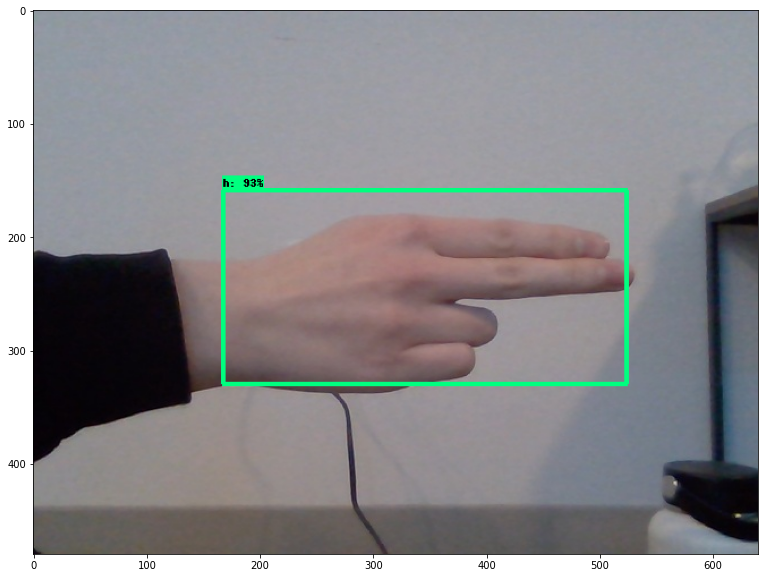

In [22]:
# Category indices.
catIndices = label_map_util.create_category_index_from_labelmap("./tensorflow/workspace/annotations/label_map.pbtxt")

# Some sample images we can test our model on.
#testImg = "./tensorflow/workspace/images/test/ea672329-r_1670919841.jpg"
#testImg = "./tensorflow/workspace/images/test/2a3f0288-e_1670919504.jpg"
#testImg = "./tensorflow/workspace/images/test/951c110e-d_1670922929.jpg"
#testImg = "./tensorflow/workspace/images/test/9592cffa-w_1670919951.jpg"
#testImg = "./tensorflow/workspace/images/test/b9fdffc3-o_1670918234.jpg"
testImg = "./tensorflow/workspace/images/test/c502e0ea-h_1670919424.jpg"
#testImg = "./tensorflow/workspace/images/test/f7bc5a1c-l_1670922700.jpg"
img = cv2.imread(testImg)
matrix = np.array(img)

# Convert to a tensor and extract detections.
tensor = tf.convert_to_tensor(np.expand_dims(matrix, 0), dtype=tf.float32)
detections = detect(tensor)

n = int(detections.pop("num_detections"))
detections = {k:v[0, :n].numpy() for k, v in detections.items()}
detections["num_detections"] = n
detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

offset = 1
matrixDetections = matrix.copy()

vis.visualize_boxes_and_labels_on_image_array(
    matrixDetections,
    detections["detection_boxes"],
    detections["detection_classes"]+offset,
    detections["detection_scores"],
    catIndices,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=0.67,
    agnostic_mode=False
)

plt.imshow(cv2.cvtColor(matrixDetections, cv2.COLOR_BGR2RGB))
plt.show()

## Step 11: Live Detection via Webcam

We can now use the webcam to detect gestures live using our trained model.

In [46]:
if not usingColab:

    cap = cv2.VideoCapture(0)

    # Loop for all gestures we want to train.
    while cap.isOpened():

        # Read from the camera.
        _, frame = cap.read()
        matrix = np.array(frame)

        # Convert to a tensor and extract detections.
        tensor = tf.convert_to_tensor(np.expand_dims(matrix, 0), dtype=tf.float32)
        detections = detect(tensor)

        n = int(detections.pop("num_detections"))
        detections = {k:v[0, :n].numpy() for k, v in detections.items()}
        detections["num_detections"] = n
        detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

        offset = 1
        matrixDetections = matrix.copy()

        vis.visualize_boxes_and_labels_on_image_array(
            matrixDetections,
            detections["detection_boxes"],
            detections["detection_classes"]+offset,
            detections["detection_scores"],
            catIndices,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=0.80,
            agnostic_mode=False
        )

        cv2.imshow("Frame", matrixDetections)

        # Press 'q' to quit.
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break

# Credits to https://colab.research.google.com/github/isnamdnazim/YOLO-V4-Object-Detection/blob/main/Real_time_YOLOv4_Object_Detection_on_Webcam_in_Google_Colab_%7C_Images_and_Video.ipynb#scrollTo=YjOa8bVj3mwV
# Google Colab needs a webcam workaround.
else:

    from IPython.display import display, Javascript, clear_output
    from google.colab.output import eval_js
    from base64 import b64decode, b64encode

    # JavaScript to properly create our live video stream using our webcam as input
    def video_stream():
      js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;
        
        var pendingResolve = null;
        var shutdown = false;
        
        function removeDom() {
          stream.getVideoTracks()[0].stop();
          video.remove();
          div.remove();
          video = null;
          div = null;
          stream = null;
          imgElement = null;
          captureCanvas = null;
          labelElement = null;
        }
        
        function onAnimationFrame() {
          if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
          }
          if (pendingResolve) {
            var result = "";
            if (!shutdown) {
              captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
              result = captureCanvas.toDataURL('image/jpeg', 0.8)
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
          }
        }
        
        async function createDom() {
          if (div !== null) {
            return stream;
          }

          div = document.createElement('div');
          div.style.border = '2px solid black';
          div.style.padding = '3px';
          div.style.width = '100%';
          div.style.maxWidth = '600px';
          document.body.appendChild(div);
          
          const modelOut = document.createElement('div');
          modelOut.innerHTML = "<span>Status:</span>";
          labelElement = document.createElement('span');
          labelElement.innerText = 'No data';
          labelElement.style.fontWeight = 'bold';
          modelOut.appendChild(labelElement);
          div.appendChild(modelOut);
              
          video = document.createElement('video');
          video.style.display = 'block';
          video.width = div.clientWidth - 6;
          video.setAttribute('playsinline', '');
          video.onclick = () => { shutdown = true; };
          stream = await navigator.mediaDevices.getUserMedia(
              {video: { facingMode: "environment"}});
          div.appendChild(video);

          imgElement = document.createElement('img');
          imgElement.style.position = 'absolute';
          imgElement.style.zIndex = 1;
          imgElement.onclick = () => { shutdown = true; };
          div.appendChild(imgElement);
          
          const instruction = document.createElement('div');
          instruction.innerHTML = 
              '<span style="color: red; font-weight: bold;">' +
              'When finished, click here or on the video to stop this demo</span>';
          div.appendChild(instruction);
          instruction.onclick = () => { shutdown = true; };
          
          video.srcObject = stream;
          await video.play();

          captureCanvas = document.createElement('canvas');
          captureCanvas.width = 640; //video.videoWidth;
          captureCanvas.height = 480; //video.videoHeight;
          window.requestAnimationFrame(onAnimationFrame);
          
          return stream;
        }
        async function stream_frame(label, imgData) {
          if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
          }

          var preCreate = Date.now();
          stream = await createDom();
          
          var preShow = Date.now();
          if (label != "") {
            labelElement.innerHTML = label;
          }
                
          if (imgData != "") {
            var videoRect = video.getClientRects()[0];
            imgElement.style.top = videoRect.top + "px";
            imgElement.style.left = videoRect.left + "px";
            imgElement.style.width = videoRect.width + "px";
            imgElement.style.height = videoRect.height + "px";
            imgElement.src = imgData;
          }
          
          var preCapture = Date.now();
          var result = await new Promise(function(resolve, reject) {
            pendingResolve = resolve;
          });
          shutdown = false;
          
          return {'create': preShow - preCreate, 
                  'show': preCapture - preShow, 
                  'capture': Date.now() - preCapture,
                  'img': result};
        }
        ''')

      display(js)
      
    def video_frame(label, bbox):
      data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
      return data

    # function to convert the JavaScript object into an OpenCV image
    def js_to_image(js_reply):
      """
      Params:
              js_reply: JavaScript object containing image from webcam
      Returns:
              img: OpenCV BGR image
      """
      # decode base64 image
      image_bytes = b64decode(js_reply.split(',')[1])
      # convert bytes to numpy array
      jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
      # decode numpy array into OpenCV BGR image
      img = cv2.imdecode(jpg_as_np, flags=1)

      return img

    # Credits to https://stackoverflow.com/questions/72312920/display-a-stream-images-in-google-colab-using-opencv
    # for this workaround again in Google Colab. Again, this is just because Colab
    # needs some kind of workaround for webcams and output. This isn't needed
    # in the native Jupyter case, but we're including support for Colab in case
    # you may be running this and not have the hardware to train the model.
    def imshow(name, img):
      """Put frame as <img src="data:image/jpg;base64,...."> """

      js = Javascript('''
      async function showImage(name, image, width, height) {
        img = document.getElementById(name);
        if(img == null) {
          img = document.createElement('img');
          img.id = name;
          document.body.appendChild(img);
        }
        img.src = image;
        img.width = width;
        img.height = height;
      }
      ''')

      height, width = img.shape[:2]

      ret, data = cv2.imencode('.jpg', img)   # compress array of pixels to JPG data
      data = b64encode(data)                  # encode base64
      data = data.decode()                    # convert bytes to string
      data = 'data:image/jpg;base64,' + data  # join header ("data:image/jpg;base64,") and base64 data (JPG)

      display(js)
      eval_js(f'showImage("{name}", "{data}", {width}, {height})')  # run JavaScript code to put image (JPG as string base64) in <img>
                                              # `name` and `data` in needs `" "` to send it as text, not as name of variabe.

    # With those workarounds out of the way, finally back to our code.

    %matplotlib inline
    video_stream()

    while True:

        jsr = video_frame("Stream", "")
        if not jsr:
            break
        frame = js_to_image(jsr["img"])
        matrix = np.array(frame)

        # Convert to a tensor and extract detections.
        tensor = tf.convert_to_tensor(np.expand_dims(matrix, 0), dtype=tf.float32)
        detections = detect(tensor)

        n = int(detections.pop("num_detections"))
        detections = {k:v[0, :n].numpy() for k, v in detections.items()}
        detections["num_detections"] = n
        detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

        offset = 1
        matrixDetections = matrix.copy()

        vis.visualize_boxes_and_labels_on_image_array(
            matrixDetections,
            detections["detection_boxes"],
            detections["detection_classes"]+offset,
            detections["detection_scores"],
            catIndices,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=0.80,
            agnostic_mode=False
        )

        imshow("Frame", cv2.cvtColor(matrixDetections, cv2.COLOR_BGR2RGB))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored